Положить все файлы с датасетами и ноутбук в одну папку



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_params # вывод результатов тестирования
from scipy.stats import t # t-распределение

Загружаем данные
можно загрузить из файла, либо по ссылке(pd.read_csv('https://raw.githubusercontent.com/ryupepa/Econometrica/master/python-notebooks/data-csv/sleep75.csv')

In [ ]:
df_sleep = pd.read_csv('sleep75.csv')

Подгоняем модель согласно спецификации


In [ ]:
mod1 = smf.ols(formula='sleep~totwrk+age+south+male+smsa+yngkid+marr+union+np.log(hrwage)', 
                       data=df_sleep).fit()
# Описательные статистики по переменным модели
df_sleep[['sleep', 'hrwage', 'smsa', 'totwrk', 'male', 'marr', 'age', 'south', 'yngkid']].describe()

In [ ]:
# коэффициенты, округленные до 3 знаков после запятой
mod1.params.round(3)

Интерпретация:
    Intercept - свободный коэффициент, обычно не интерпретируется
    
    sleep~male - при прочих равных(участвующих в регрессии), для male = 1, в среднем, sleep ,больше на коэффициент, чем для male = 0
    
    sleep~np.log(hrwage) - при увеличение hrwage на 1%, абсолютное значение sleep будет на коэффициент/100 больше
    np.log(sleep)~np.log(hrwage) - эластичноть sleep по hrwage при )увеличение hrwage на 1%, значение sleep будет на коэффициент % больше)
    sleep~hrwage - при увеличение hrwage на 1, абсолютное значение sleep будет на коэффициент больше
    np.log(sleep)~hrwage - при увеличение hrwage на 1, абсолютное значение sleep будет на коэффициент * 100% больше(на сколько рынок оценивает один балл IQ)
    
    
    **возраст и ставки не логарифмируются

In [ ]:
# Число наблюдений в модели, число регрессоров и степени свободы для t_cr
mod1.nobs, mod1.df_model, mod1.df_resid

Вывод: наблюдения с пропущенными значениями были удалены при оценивании модели
    

In [ ]:
# adj R^2
mod1.rsquared_adj

Не интерпретируется

In [ ]:
# R^2
mod1.rsquared

    Интерпретация - насколько определенная комбинация переменных X поясняет отклонение Y (зависимой переменной)

In [ ]:
# TSS - общая сумма квадратов
mod1.centered_tss

In [ ]:
# ESS - объясненная сумма квадратов
mod1.ess

In [ ]:
# RSS - остаточная сумма квадратов
mod1.ssr

In [ ]:
# стандартное отклонение регрессии
mod1.mse_resid**0.5

Наблюдения нумеруются  с 0

Как доставать конкретные предсказанные значения и другие штуки для наблюдений

In [ ]:
# создаем массив номеров  нужных наблюдений
ind = np.array([1, 4, 6, 10, 508, 500])-1

In [ ]:
# Предсказанные значения
mod1.fittedvalues[ind]

In [ ]:
# Остатки
mod1.resid[ind]

In [ ]:
# Фактические значения
df_sleep['sleep'].iloc[ind]

Фильтрация данных (значение в столбце smsa = 1)

In [ ]:
# new_df_name = df_name[df_name['smsa'] = 1]

# Срез 2 

1. t-тест: значимость коэффициента и общий случай
2. F-тест: значимость регрессии
3. F-тест: совместная значимость
4. F-тест: общие линейные ограничения 
5. F-тест: структурные изменения
6. Доверительные интервалы


In [11]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_params # вывод результатов тестирования
from statsmodels.iolib.summary2 import summary_col # вывод подгонки

from scipy.stats import t # t-распределение
from scipy.stats import f # F-распределение
import seaborn as sns

import matplotlib.pyplot as plt
import random
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 11,7

## 1.1 t-тест: H0: β=0

Тестируем гипотезу о незначимости переменной

Тестовая статистика $$t=\frac{\hat{\beta}}{s.e.(\beta)}$$
    
Критическое $$t_{cr}=t_{df=n-k-1}(\alpha)$$

Принимаем гипотезу, если $t_{cr}>t_{df=n-k-1}(\alpha)$ или $P > \alpha$ 

иначе отвергаем, и тогда переменная значима


Как выбираем уровень значимости $\alpha$

Стандартные значения 10%, 5%, 1%, 0.1% и тд
Чем больше датасет, тем меньше берем уровень значимости

*** - 0.001 ** - 0.01 * - 0.05 . - 0.1

In [ ]:
# Загрузим данные
df_sleep = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/sleep75.csv')
mod1 = smf.ols(formula='sleep~totwrk+age+south+male+smsa+yngkid+marr+union+np.log(hrwage)', 
                       data=df_sleep).fit()
# коэффициенты
mod1.params.round(3)

In [ ]:
# Число наблюдений в модели, число регрессоров и степени свободы для t_cr
mod1.nobs, mod1.df_model, mod1.df_resid


In [ ]:
# 5%-критическое значение t-распределения
t.ppf(q=1-0.05/2, df=mod1.df_resid)

Тестируем значимость переменных totwrk и male

In [ ]:
mod1.t_test('totwrk=0, male=0')

P-значение  totwrk  < $\alpha = 0,05$ и |t-статистка| > $t_{cr}$
Отвергаем гипотезу о незначимости totwrk и делаем вывод, что при выбранном $\alpha$ totwrk является значимым 

Для male ситуация прямопротивоположная

In [ ]:
#Смотрим на значимость всех переменных
summary_params(mod1)#.round(3)

In [ ]:
# стандартные ошибки s.e.(beta)
mod1.bse

In [ ]:
# t-статистики
mod1.tvalues

In [ ]:
# p-values
mod1.pvalues.round(3)

Видим, что по значениям p-value в данной регрессии при заданном уровне зачимости в 5% значимы только переменные totwrk и south

## 1.2 Общий t-test
Тестируем $$H_0:\beta=\theta$$ ($\theta$ - заданное число)
   Тестовая статистика $$t=\frac{\hat{\beta}-\theta}{s.e.(\beta)}$$
    
   


In [ ]:
# Загрузим данные
df_labour = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/Labour.csv')
# Результаты подгонки
mod2 = smf.ols(formula='np.log(output)~np.log(capital)+np.log(labour)', data=df_labour).fit()
summary_params(mod2) # По дефолту тестирует знаачимость переменной, а не равенство коэффициента чему-то

Будем проверять гипотезу $H_0: \beta_{capital} = 0.5$ на уровне значимости $\alpha = 0.01$

In [ ]:
mod2.t_test('np.log(capital)=0.5')

In [ ]:
# 1%-критическое значение t-распределения
t.ppf(q=1-0.01/2, df=mod2.df_resid)

P-значение  < $\alpha = 0,01$ и |t-статистка| > $t_{cr}$

Отвергаем гипотезу и делаем вывод, что при выбранном $\alpha$ коэффициент перед capital значимо отличаается от 0.5

## 2. F-test: значимость регрессии

Тестируется гипотеза (ни один регрессор не является значимым)
    $$H_0:\beta_1=\cdots=\beta_k = 0 $$
Тестовая статистика (неробастная) $$F = \frac{R^2}{1 - R^2}\cdot\frac{n - k - 1}{k}$$
Критическое значение $$F_{cr}=F_{df1 = k, df2 = n - k - 1}(\alpha)$$
Гипотеза отвергается если $F > F_{cr}$ или $P < \alpha$



$R^2$ показывает, насколько регрессия объясняет значения,

    если $R^2$ маленький, но влияние выбранных регрессоров значимо, то ок
    
    если регрессия не значима, то it's trash

In [ ]:
# загрузим данные
sleep_df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/sleep75.csv')
# подгоним модель
mod3 = smf.ols(formula='sleep~totwrk+age+I(age**2)+south+male+smsa+yngkid+marr+union', data=sleep_df).fit()

Результаты F-теста на значимость регрессии (тестовая статистика и P-значение)

In [ ]:
mod3.fvalue, mod3.f_pvalue

5%-критическое значение F-распределения

In [ ]:
f.ppf(q = 1 - 0.05, dfn = mod3.df_model, dfd = mod3.df_resid)

P-значение  < $\alpha = 0,05$ и |F-статистка| > $F_{cr}$
Отвергаем гипотезу о незначимости регрессии и делаем вывод, что при выбранном $\alpha$ регрессия является значимой

In [ ]:
# Тестовая статистика по формуле
mod3.rsquared/(1-mod3.rsquared)*(mod3.df_resid/mod3.df_model)

Альтернативный способ: явно специфицируем тестируемую гипотезу

In [ ]:
print( mod3.f_test('totwrk = 0, age = 0, I(age**2) = 0, south = 0, male = 0, smsa = 0, yngkid = 0, marr = 0, union = 0') )

## 3. F-тест: совместная значимость

Тестируется гипотеза (выбираем, какие значения занулять сами по каким-то своим соображениям)
    $$H_0:\beta_1=\cdots=\beta_J=0 $$
   Тестовая статистика (неробастная) $$F=\frac{R^2 - R^2_{restr}}{1 - R^2}\cdot\frac{n - k - 1} {J}=\frac{RSS_{restr} - RSS}{RSS}\cdot\frac{n - k - 1}{J}$$
    
$R^2_{restr}, RSS_{restr}$ – из промежуточной регрессии с ограничениями (нужна доп регрессия для $R^2$ без этих переменных)  
$J$ - количество ограничений на коэффициенты
    
Критическое значение $$F_{cr}=F_{df1=J, df2= n - k - 1}(\alpha)$$
    
Гипотеза отвергается если $F > F_{cr}$ или $P < \alpha$

### Для датасета sleep75 рассмотрим регрессию sleep на totwrk, age, male, south, smsa, yngkid, marr, union

Результаты подгонки

In [ ]:
sleep_df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/sleep75.csv')
mod4 = smf.ols(formula='sleep~totwrk+age+male+south+smsa+yngkid+marr+union', data=sleep_df).fit()
summary_col(mod4, stars=True)

Потестируем совместную значимость `smsa, yngkid, marr, union`, т.е. гипотезу
   $$H_0:\beta_{smsa} = \beta_{yngkid} = \beta_{marr} = \beta_{union} = 0$$
   Критическое значений: df1 = 4, df2 = n - k - 1

In [ ]:
f.ppf(q=1-0.05, dfn=4, dfd=mod4.df_resid)

### Первый способ: через спецификацию гипотезы

In [ ]:
# F-статистика, p-value, df2, df1
print( mod4.f_test('smsa=yngkid=marr=union=0') )
print( mod4.wald_test('smsa=yngkid=marr=union=0', use_f=True) )

### Второй способ: через вспомогательную регрессию с ограничениями

In [ ]:
# F-статистика, p-value, df1
mod4_restr = smf.ols(formula='sleep~totwrk+age+male+south', data=sleep_df).fit()
mod4.compare_f_test(mod4_restr)

### Явное вычисление


In [ ]:
(mod4.rsquared - mod4_restr.rsquared) / (1 - mod4.rsquared) * mod4.df_resid / 4

In [ ]:
(mod4_restr.ssr - mod4.ssr) / mod4.ssr * mod4.df_resid / 4

## 4. F-тест: Линейные ограничения

Тестируется гипотеза о линейных ограничения на коэффициенты **(в матричной форме)**
    $$H_0: R\beta = q$$
Тестовая статистика (неробастная) $$F=\frac{1}{J}(R\hat{\beta} - q)^\top(R\hat{V}R^\top)^{-1} (R\hat{\beta} - q)\quad \hat{V} = s^2(X^\top X)^{-1}$$
    
Критическое значения ($J$ – число независимых ограничений) $$F_{cr} = F_{df1 = J, df2 = n - k - 1}(\alpha)$$

Гипотеза отвергается если $F > F_{cr}$ или $P < \alpha$"

Для набора данных `Labour` рассмотрим линейную регрессию **log(output) на log(capital), log(labour), log(wage)**
    
Вектор коэффициентов для этой модели $$beta=\begin{pmatrix} const & \beta_{capital} & \beta_{labour} & \beta_{wage} \end{pmatrix}^\top$$

Результаты подгонки

In [ ]:
labour_df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/Labour.csv')
mod = smf.ols(formula='np.log(output)~np.log(capital)+np.log(labour)+np.log(wage)', data=labour_df).fit()
mod.summary()

### Гипотеза 1
Тестируем $H_0:\beta_{capital} + \beta_{labour} + \beta_{wage} = 1$

In [ ]:
# F-статистика, p-value, df2, df1
print( mod.f_test('np.log(capital)+np.log(labour)+np.log(wage)=1') )


In [ ]:
# критическое значение
f.ppf(q=1-0.05, dfn=1, dfd=mod.df_resid)

*Техничеcкие подробности*: Запишем ограничение в матричном виде $R\beta = q$ как систему линейных уравнений. Имеем

   \begin{align}
       R&=\begin{pmatrix} 0 & 1 & 1 & 1 \end{pmatrix}&  q&=1
    \end{align}

In [ ]:
 print( mod.f_test( r_matrix=([0, 1, 1, 1], 1) ) )

### Гипотеза 2
Тестируем $H_0:\beta_{labour}=\beta_{wage}$

Альтернативная запись $H_0:\beta_{labour} - \beta_{wage} = 0$"

In [ ]:
# F-статистика, p-value, df2, df1
print( mod.f_test('np.log(labour)=np.log(wage)') )

In [ ]:
# критическое значение
f.ppf(q=1-0.05, dfn=1, dfd=mod.df_resid)

*Техничеcкие подробности*: Запишем ограничение в матричном виде $R\beta = q$ как систему линейных уравнений. Имеем

   \begin{align}
       R&=\begin{pmatrix} 0 & 0 & 1 & -1 \end{pmatrix}&  q&=0
    \end{align}

In [ ]:
 print( mod.f_test( r_matrix=([0, 0, 1, -1], 0) ) )

## 5. F-тест: Структурные изменения

Рассмотрим регрессию **sleep/60 на totwrk, age, age^2, south, smsa, marr**

* для М $sleep/60=\beta_0 + \beta_1totwrk + \beta_2age + \beta_3age^2 + \beta_4south + \beta_5smsa + \beta_6marr + u$
    
* для Ж $sleep/60 = \gamma_0 + \gamma_1totwrk + \gamma_2age + \gamma_3age^2 + \gamma_4south + \gamma_5smsa + \gamma_6marr + v$
    
Будем тестировать $H_0: \beta_j = \gamma_j$ (всего $k + 1$ ограничение)
    
Уровень значимости $\alpha = 0.01$
    
Для тестовой статистики подговим модель
* только по М
* только по Ж
* по полному датасету
    
Результаты подгонки

In [ ]:
sleep_df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/sleep75.csv')
specification = 'I(sleep/60)~totwrk+age+I(age**2)+south+smsa+marr'
# подгонка по полному датасету
mod_overall = smf.ols(formula=specification, data=sleep_df).fit()
# подгонка только по М
mod_men_only = smf.ols(formula=specification, data=sleep_df[ sleep_df['male']==1 ]).fit()
# подгонка только по Ж
mod_women_only = smf.ols(formula=specification, data=sleep_df[ sleep_df['male']==0 ]).fit()
# Вывод трёх регрессий в одной таблице
summary_col(results=[mod_men_only, mod_women_only, mod_overall], stars=True, model_names=['муж', 'жен', 'Общая'],
           info_dict={'N': lambda x: x.nobs, 'F-stat': lambda x: x.fvalue})

In [ ]:
# Ингредиенты тестовой статистики
print('RSS (overall) =', mod_overall.ssr)
print('RSS (men_only) =', mod_men_only.ssr)
print('RSS (women_only) =', mod_women_only.ssr)
print('n =', mod_overall.nobs)
print('k =', mod_overall.df_model)

Тестовая статистика $$F=\frac{RSS_{overall} - RSS_{men} - RSS_{women}}{RSS_{men} + RSS_{women}}*\frac{n - 2(k + 1)}{k + 1}$$

Критическое значение $$F_{cr}=F_{df1 = k + 1, df2 = n - 2(k + 1)}(\alpha)$$

In [ ]:
#F-статистика, F критическое
F = (mod_overall.ssr - mod_men_only.ssr - mod_women_only.ssr) / (mod_men_only.ssr + mod_women_only.ssr) * (mod_overall.nobs - 2 * (mod_overall.df_model + 1)) / (mod_overall.df_model + 1)
F_cr = f.ppf(q =  1 - 0.01, dfn = mod_overall.df_model + 1, dfd = mod_overall.nobs - 2 * (mod_overall.df_model + 1))
F, F_cr

|F-статистка| < $F_{cr}$
Принимаем гипотезу о том, что коэффициенты перед регрессорами **totwrk, age, age^2, south, smsa, marr** для Ж и М одинаковы при выбранном $\alpha$

структурных сдвигов отдачи от **totwrk, age, age^2, south, smsa, marr** относительно гендерной переменной не наблюдается

In [ ]:
#линейнаая функция
sns.lmplot(data=sleep_df, x='totwrk', y='sleep', hue='male', ci=False, markers='.')

In [ ]:
#квадратичный многочлен
sns.lmplot(data=sleep_df, x='age', y='sleep', hue='male', ci=False, markers='.', order=2)

## 6. Доверительные интервалы

Пусть $\gamma$ – доверительная вероятность и $t_{cr} = t_{df = n - k - 1}(\alpha = 1 - \gamma)$

Доверительный интервал для коэффициента $\beta$:
$$\left(\hat{\beta} - t_{cr}\cdot s.e.(\beta)\, ,\, \hat{\beta} + t_{cr}\cdot s.e.(\beta)\right)$$

Для набора данных `Labour` рассмотрим регрессию **log(output) на log(capital) и log(labour)**

In [ ]:
labour_df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/Labour.csv')
mod5 = smf.ols(formula='np.log(output)~np.log(capital)+np.log(labour)', data=labour_df).fit()
mod5.summary()

Построим 95%-доверительные интервалы для каждого коэффициента ($\gamma = 0.95$, $\alpha = 0.05$)

In [ ]:
mod5.conf_int(alpha = 0.05)

In [ ]:
# ручное построение c.i.
t_cr = t.ppf(q=1-0.05/2, df=mod5.df_resid)
mod5.params-mod5.bse*t_cr, mod5.params+mod5.bse*t_cr

Построим 90%-доверительные интервалы для каждого коэффициента ($\gamma = 0.90$, $\alpha = 0.10$)

In [ ]:
mod5.conf_int(alpha = 0.1)

### Создадим набор случайных чисел из миллиона элементов

In [12]:
N = 10000000 #Создадим случайные массив чисел 
x = np.random.randint(-100, 100, N) # Значения для игра выбереме случайным образом.

 Создадим выборку из 50-ти элементов для 50-ти интервалов.

In [13]:
lv =50 # размер выборки
vyborki = []
means_val = []
stan_err = []
for i in range(0, lv):
    vyborki.append(random.choices(x, k=lv))

 Для каждого из интервалов найдём его среднее значение и исправленную выборчную дисперсию

In [14]:
T = t.ppf(0.975,lv-1) # Из таблицы Стьюдента берем значение
for item in vyborki:
    means_val.append(np.mean(item)) # Для каждого интервала находим среднее значение
    stan_err.append(np.sqrt(np.var(item, ddof=1))/np.sqrt(lv)) # Для каждого интервала находим среднее выборочное отклонение

 Отобразим доверительные интервалы

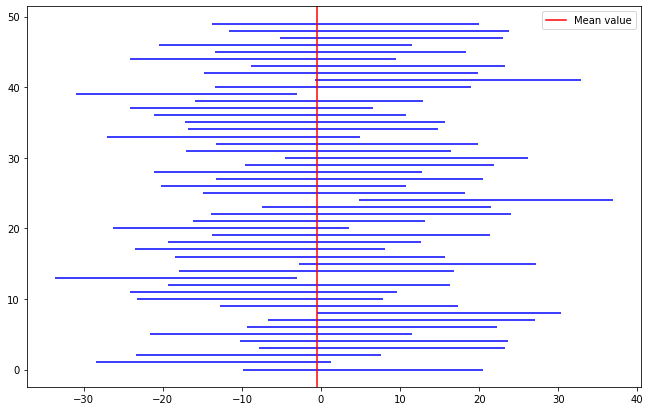

In [16]:
fig, ax = plt.subplots()
legends = ['Mean value']
for j in range(0, lv):
    ax.hlines(j,means_val[j] - T * stan_err[j],  means_val[j] + T * stan_err[j], color='blue', linestyles='-') 
ax.axvline(x=np.mean(x), color='red',label='Mean value' )
ax.legend()
plt.show()

* Три интервала из 50ти не пересекаются с средним значением генеральной выборки. Другими словами, 5% интервалов не содержат истинное значение среднего значение генеральной выборки.*